In [1]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import sys
import csv
import functools
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_pickle("./4_MASDEV_Cleaned.pkl")
df.shape

(25677, 49)

In [3]:
df["RECALL_CLASS"].value_counts()

1    15811
0     9866
Name: RECALL_CLASS, dtype: int64

<AxesSubplot:xlabel='RECALL_CLASS', ylabel='count'>

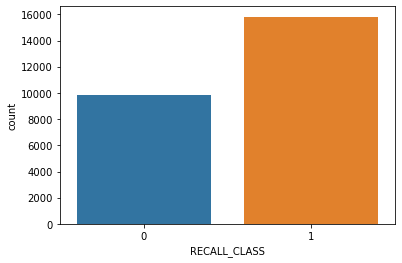

In [4]:
sns.countplot(x="RECALL_CLASS", data=df)

In [5]:
# creating dfs based on recall class
df_recall0 = df[df["RECALL_CLASS"] == "0"]
print(df_recall0.shape)
df_recall0.head()

(9866, 49)


,MDR_REPORT_KEY,MDR_TEXT_KEY,TEXT_TYPE_CODE,PATIENT_SEQUENCE_NUMBER,DATE_REPORT,FOI_TEXT,textLen,REPORT_NUMBER,REPORT_SOURCE_CODE,MANUFACTURER_LINK_FLAG_,...,MEDTRONIC_VISIA,BOS_SCI_EMBLEM,StJUDE_ELLIPSE,MEDTRONIC_SPRINT,MEDTRONIC_SPRINT_QUATTRO,MEDTRONIC_SUBQ,MEDTRONIC_CROME,CENSORED,_merge,CLEAN_FOI_TEXT
0,263098,147618,D,1,NaN,OVERSENSING FROM LEAD FRACTURE CAUSED PT TO RE...,NaN,2182208-2000-00025,M,Y,...,False,False,False,True,False,False,False,2000-01-10,both,oversens lead fractur caus pt receiv unnecessa...
1,291837,148901,D,1,NaN,"SYSTEM RETURNED FOR LEAD FRACTURES, BURN MARK ...",NaN,2649622-2000-00207,M,Y,...,False,False,False,True,False,False,False,2000-05-12,both,system return lead fractur burn mark long char...
2,292539,182872,D,1,NaN,PACING THRESHOLD INCREASE,NaN,2649622-2000-00385,M,Y,...,False,False,False,True,False,False,False,2000-07-11,both,pace threshold increas
3,292547,182873,D,1,NaN,"SENSING DIFFICULTY, INSULATION DAMAGE",NaN,2182208-2000-00251,M,Y,...,False,False,False,True,False,False,False,2000-07-11,both,sens difficulti insul damag
4,292558,20930497,D,1,NaN,"APPARENT LEAD FRACTURE, NOISE.",NaN,2649622-2000-00364,M,Y,...,False,False,False,True,False,False,False,2000-07-11,both,appar lead fractur nois


In [6]:
df_recall1 = df[df["RECALL_CLASS"] == "1"]
print(df_recall1.shape)
df_recall1.head()

(15811, 49)


,MDR_REPORT_KEY,MDR_TEXT_KEY,TEXT_TYPE_CODE,PATIENT_SEQUENCE_NUMBER,DATE_REPORT,FOI_TEXT,textLen,REPORT_NUMBER,REPORT_SOURCE_CODE,MANUFACTURER_LINK_FLAG_,...,MEDTRONIC_VISIA,BOS_SCI_EMBLEM,StJUDE_ELLIPSE,MEDTRONIC_SPRINT,MEDTRONIC_SPRINT_QUATTRO,MEDTRONIC_SUBQ,MEDTRONIC_CROME,CENSORED,_merge,CLEAN_FOI_TEXT
3456,2819669,2920967,D,1,NaN,IT WAS REPORTED THAT THE SYSTEM WAS EXPLANTED ...,NaN,2017865-2012-09571,M,Y,...,False,False,True,False,False,False,False,2012-11-05,both,it report the system explant due infect
3457,2819620,2927864,D,1,NaN,THIS REPORT IS TO ADVISE OF AN EVENT OBSERVED ...,NaN,2017865-2012-09564,M,Y,...,False,False,True,False,False,False,False,2012-11-05,both,thi report to advis an event observ analysi
3458,2828234,2936439,D,1,NaN,IT WAS REPORTED THAT DURING INTERROGATION PRIO...,NaN,2017865-2012-10402,M,Y,...,False,False,True,False,False,False,False,2012-11-12,both,it report dure interrog prior av node ablat su...
3459,2828706,2938772,D,1,NaN,IT WAS REPORTED THAT CROSSTALK WAS NOTED ON TH...,NaN,2017865-2012-10401,M,Y,...,False,False,True,False,False,False,False,2012-11-12,both,it report crosstalk note the ventricular lead ...
3460,2825875,2941544,D,1,NaN,IT WAS REPORTED THAT THE SYSTEM WAS EXPLANTED ...,NaN,2017865-2012-09989,M,Y,...,False,False,True,False,False,False,False,2012-11-08,both,it report the system explant due infect


In [7]:
# undersampling
udf_recall0 = df_recall0.sample(n=9866)
print(udf_recall0.shape)
udf_recall1 = df_recall1.sample(n=9866)
print(udf_recall1.shape)

(9866, 49)
(9866, 49)


(19732, 49)


<AxesSubplot:xlabel='RECALL_CLASS', ylabel='count'>

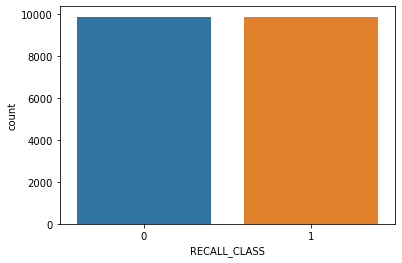

In [8]:
udf = udf_recall0
udf = udf.append(udf_recall1)
print(udf.shape)
sns.countplot(x="RECALL_CLASS", data=udf)

In [9]:
odfsame_recall0 = pd.concat([df_recall0]*2, ignore_index=True)
odfsame_recall0 = odfsame_recall0.sample(n=15811)
print(odfsame_recall0.shape)

(15811, 49)


(31622, 49)


<AxesSubplot:xlabel='RECALL_CLASS', ylabel='count'>

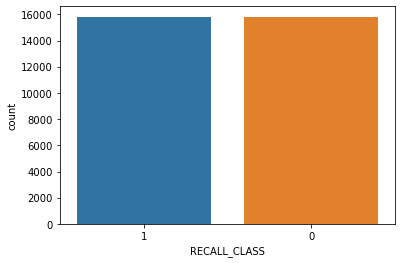

In [10]:
odfsame = df_recall1
odfsame = odfsame.append(odfsame_recall0)
print(odfsame.shape)
sns.countplot(x="RECALL_CLASS", data=odfsame)

In [11]:
udf.to_pickle("./4_COMB_FILE_UNDERSAMPLING")
odfsame.to_pickle("./4_COMB_FILE_OVERSAMPLING")
df.to_pickle("./4_COMB_FILE_UNBALANCED.pkl")

In [12]:
# different variations of oversampling were not used due to the relative similarity of the recall class sizes